## Project
### Analyzing (in)solvency factors for the credit department of a bank

**Client:** the credit and dunning department of a bank.

**Data:** bank data on customer's solvency. 

**Task:**
based on customer solvency statistics, investigate whether the following factors influence the likelihood of repaying a loan on time:
1. marital status
2. number of children
3. level of income
4. purpose of loan

------------

### Table of Contents

1. [General Information](#step1)
2. [Data Preprocessing](#preprocessing) <br>
    2.1. [Handling Missing Values](#missing) <br>
    2.2. [Correcting Data Type(s)](#types) <br>
    2.3. [Handling Duplicates](#duplicates) <br>
    2.4. [Lemmatization](#lemmatization) <br>
    2.5. [Categorizing Data](#categorization) <br>
3. [Analysis of Factors](#analysis) <br>
    3.1. [Number of Children](#children) <br>
    3.2. [Marital Status](#marital) <br>
    3.3. [Income Level](#income) <br>
    3.4. [Loan Purpose](#purposes) <br>
4. [Final Summary](#final_summary)
5. [Backup](#backup)

<a name="step1"></a>

In [1]:
# standard libraries
import pandas as pd
import numpy as np

# for lemmatization
from pymystem3 import Mystem 

# for progress tracking
from tqdm import tqdm

# for counting values
from collections import Counter

# for visualizations
import matplotlib.pyplot as plt

### 1. General Information <a name="step1"></a>

In [2]:
# opening the file and reviewing the first rows
df = pd.read_csv("data.csv")

df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


-----

**Interim Summary**

At first glance, the data reveals the following:
- the dataset consists of a total of 12 variables and 21525 observations;
- some variables contain missing values: *days_employed*, *total_ income*
- there is a suspicion that some variables are of the wrong type: for example, *days_employed* makes sense to make an integer
- it is also striking that some variables are written in an inappropriate format: for example, *days_employed* has got negative values, and the some other fraction of obsevations exceeds hundreds of thousands of days (which does not seem to be a plausible value)

-----

### 2. Data Preprocessing <a name="preprocessing"></a>

#### 2.1. Handling Missing Values <a name="missing"></a>

###### 2.1.1. Straight* Missing Values

(* already marked as NaN)

In [4]:
# counting missing values
missing_values_sum = df["total_income"].isna().sum()
print("Total number of rows with missing values:", missing_values_sum)
print("Share of such rows among all observations: {:.1%}".format(missing_values_sum / len(df)))

Total number of rows with missing values: 2174
Share of such rows among all observations: 10.1%


-------

**Interim Summary**

As it was revealed in Step 1, the variable `days_employed` seems to have inappropriate values, e.i. there are negative and very large values.

As shown by visual analysis of the variable ([Backup](#backupvisual)):
- large values are similar to noise and it is very difficult to attribute them to any logical age equivalent;
- negative values are similar to real data (but with an accidentally added minus)

Thus, we will convert very large values to NaN.

------

In [5]:
# let us create corresponding funtion which converts certain values to NaN
def nan_converter(n):
    if n > 0:
        return np.nan
    else:
        return n

In [6]:
# applying the function
df["days_employed"] = df["days_employed"].apply(nan_converter)

In [7]:
# checking results
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,NaN,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [8]:
missing_values_sum = df["days_employed"].isna().sum()
print("Total number of rows with missing values:", missing_values_sum)
print("Share of such rows among all observations: {:.1%}".format(missing_values_sum / len(df)))

Total number of rows with missing values: 5619
Share of such rows among all observations: 26.1%


Let us handle NaN values for variable `total_income`

In [9]:
# finding observations with missing values and saving them in a separate dataframe for subsequent analysis
df_missing = df[df["total_income"].isna()]
df_missing.tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости
21510,2,NaN,28,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,приобретение автомобиля


----

**Interim Analysis**

Missing values are based in two columns:
- total work experience in days (`days_employed`)
- monthly income (`total_income`)

The main hypothesis is that these values are accidental, e.i. either this information for a given customer is stored on another medium within the credit department, or it is lost. It is difficult to imagine that such data as work experience and monthly income were not collected when the loan was issued.
    
-----

Verifying whether variables are distributed in the same (or comparable manner) in the full dataset and the dataset with missing values. Below the analysis for `income_type`. Analysis for other variables can be found in [Backup](#backupmissing).

The approach is to calculate share of possile values for `income_type` in full dataset and in the dataset with missing values. Afterwards, we can visually compare if the difference is significant.

In [10]:
income_type_count_missing = pd.DataFrame(df_missing["income_type"].value_counts().sort_values())
income_type_count_missing["share_missing"] = income_type_count_missing["income_type"] / df_missing["income_type"].value_counts().sum()

income_type_count_full = pd.DataFrame(df["income_type"].value_counts().sort_values())
income_type_count_full["share_full"] = income_type_count_full["income_type"] / df["income_type"].value_counts().sum()

income_type_count_full.merge(income_type_count_missing, left_index=True, right_index=True, how="outer").round(3)[["share_full", "share_missing"]]

,share_full,share_missing
безработный,0.000,NaN
в декрете,0.000,NaN
госслужащий,0.068,0.068
компаньон,0.236,0.234
пенсионер,0.179,0.190
предприниматель,0.000,0.000
сотрудник,0.517,0.508
студент,0.000,NaN


-----

**Interim Analysis**

Comparison of the rows with missing values and the entire dataset demonstrates the randomness of the missing data, since the difference in shares for each category of variables is minimal (the largest: 0.009 percentage points in the category "employee")
 
**Approach to Imputing Missing Values**
    
We fill in the missing values based on group medians. The groups median will be found  based on the available characteristics - age, education, gender, marital status and source of income.

-------------

First, we categorize the `dob_years` variable to get a better variable for grouping according to age.
Let's try to combine them into five-year preiods: 16-20, 21-25 and so on.
Let us define the corresponding function.

In [11]:
# Defining the function
ages_groups = list(range(16, 101, 5))
def age_grouping(age):
    for n in ages_groups:
        if age in range(n, n+5):
            return ages_groups.index(n)

Let's apply the function to the variable `dob_years` and create a new variable `dob_years_group`

In [12]:
# applying the function
df["dob_years_group"] = df["dob_years"].apply(age_grouping)
df.tail(2)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_group
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,4.0
21524,2,-1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля,4.0


Imputing NaN for monthly income data

In [13]:
df['total_income'] = df.groupby(["gender", 
                                     "family_status_id", 
                                     "education_id", 
                                     "income_type", 
                                     "dob_years_group"])['total_income'].apply(lambda x: x.fillna(x.median()))

Imputing NaN for work experience data

In [14]:
df['days_employed'] = df.groupby(["gender", 
                                     "family_status_id", 
                                     "education_id", 
                                     "income_type", 
                                     "dob_years_group"])['days_employed'].apply(lambda x: x.fillna(x.median()))

###### 2.1.1. Implicit* Missing Values

(* Zeros or impossible values)

Counting missing values

In [15]:
# checking missing values again
print("Number of missing values:", df["total_income"].isna().sum())
print()
# checking the values
df[df["total_income"].isna()].head()

Number of missing values: 125



,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_group
99,0,NaN,0,Среднее,1,женат / замужем,0,F,пенсионер,0,NaN,автомобиль,NaN
149,0,NaN,0,среднее,1,в разводе,3,F,сотрудник,0,NaN,операции с жильем,NaN
270,3,NaN,0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,ремонт жилью,NaN
389,1,NaN,31,СРЕДНЕЕ,1,в разводе,3,M,госслужащий,0,NaN,дополнительное образование,3.0
578,0,NaN,0,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,строительство собственной недвижимости,NaN


Counting zero values

In [16]:
# checking zero values 
print("Number of zero values:", (df["dob_years"] == 0).sum())

Number of zero values: 101


It seems that for one part of missing values, there were no groups to calculate median on.
As those are only 125 observations or around 0.5% of all rows, we can delete them without losing much information

In [17]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

The `dob_years` variable has got a zero for certain observations, although it should not be possible. 
Probably, zero corresponds to an unwillingness of the customer to provide data or simply to a lack of relevant data in the system. There is a total of 101 rows with such zeros (0.47% of the dataset). These nulls can also be deleted.

In [18]:
df = df[df["dob_years"] != 0].reset_index(drop=True)

Looking at unique values of all other variable to see if there are any anomalies that can also be attributed to implicit missing values

In [19]:
# 
for col in list(df.columns):
    print(col)
    print(df[col].unique())
    print()

children
[ 1  0  3  2 -1  4 20  5]

days_employed
[-8437.67302776 -4024.80375385 -5623.42261023 ... -4529.31666318
 -2113.3468877  -3112.4817052 ]

dob_years
[42 36 33 32 27 43 50 35 41 40 54 56 26 48 24 21 28 47 34 25 31 30 20 49
 37 45 61 44 53 46 23 38 52 39 51 62 29 59 55 64 58 60 22 63 69 57 65 19
 67 71 66 72 68 70 75 74 73]

education
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'УЧЕНАЯ СТЕПЕНЬ' 'ученая степень']

education_id
[0 1 2 3 4]

family_status
['женат / замужем' 'гражданский брак' 'в разводе' 'Не женат / не замужем'
 'вдовец / вдова']

family_status_id
[0 1 3 4 2]

gender
['F' 'M' 'XNA']

income_type
['сотрудник' 'компаньон' 'госслужащий' 'студент' 'предприниматель'
 'в декрете']

debt
[0 1]

total_income
[253875.6394526  112080.01410244 145885.95229686 ...  89672.56115303
 244093.05050043  82047.41889948]

purpose
['покупка жилья' 'приобретение автомоби

-----

**Interim Analysis**

Three problems were identified among following variables:

- First, the variable `children`. The number of children in some cases is -1 and 20. If the first value is impossible, then the second is so unlikely that we'd decide to treat it as impossible also. Probably, these values were used as a marker for missing data of a particular customer.

- Second, the variable `education` contains a number of categories which have the same meaning.

- Third, the variable `gender` contains one `XNA` value that cannot be attributed to any of the known genders.

------

Looking into how many problematic observations we have got.

In [20]:
print("Number of rows with 20 children:", len(df[df["children"] == 20]))
print("Number of rows with -1 children:", len(df[df["children"] == -1]))
print("Number of rows with gender XNA:", len(df[df["gender"] == "XNA"]))

Number of rows with 20 children: 66
Number of rows with -1 children: 39
Number of rows with gender XNA: 1


Since the total number of such rows does not exceed half a percent of the entire dataset, we can delete them without significant loss of information.

In [21]:
df = df[df["children"] != 20].reset_index(drop=True)
df = df[df["children"] != -1].reset_index(drop=True)
df = df[df["gender"] != "XNA"].reset_index(drop=True)

----------
    
**Interim Summary**

#### 1. Handling Explicit Missing Values: NaN
**Remove vs Replace**

The original dataset found 2174 rows containing `NaN` values. The option to remove them was rejected for two reasons:
1. Such missing values are placed in two columns: `days _employed` and `total_ income`. From a credit business standpoint, both are important.
2. There are too many observations with missing values, e.i. around 10% of the entire dataset (if taking into account the impossible values to NaN - more than 25% of the dataset). Removing them will result in the loss of a large amount of information.
Therefore, the option to impute them seems to be preferable.

**Imputation Method**

The missing values are non-systematic/random (see [Backup](#backupmissing) for details). The shares of various categories of variables are identical in the entire dataset and in a dataset consisting only of missing values. Hence, medians were used as imputation values. They were calculated for groups formed on the basis of different values of the variables (age, marital status, education level, gender and source of income). Unlike using one median of the entire dataset, using multiple medians by groups should keep the overall variance in the dataset higher (which is useful for further analysis).

#### 2. Handling Implicit Missing Data: zeros and impossible values
1. After step 1 from above, some rows still possesses missing balues (~120 rows or ~0.5% of the dataset), where the imputation did not work, since the corresponding group to calculate a median was not found in the data.
2. The `dob_years` variable contains zero values. Probably, zero corresponds to the unwillingness to provide the data by the borrower or simply the absence of relevant data in the system. There are 101 such lines or 0.47% of the dataset.
3. The variables `children` and `gender` contained (nearly) impossible values (the number of children is equal to -1 or 20, and gender is XNA). Rows with these values were removed (they took up less than half of a percent of the dataset).

The rows with missing values from cases above were removed, since they correspond to the fraction of the dataset that can be neglected without significant loss of information.

---------------

#### 2.2. Correcting data type(s)  <a name="types"></a>

Upon initial analysis of the table, one invalid data type was identified by the variable `days_employed`.
The number of days is an integer value while it is stored in the table as a negative floating point number.

In [22]:
# Performing corresponding correction
df["days_employed"] = df["days_employed"].astype("int")

In [23]:
# Changing the sign
df["days_employed"] = abs(df["days_employed"])

-----

**Interim Summary**

The variable `days_employed` was written in the original dataset as a negative floating point value, although it must be a positive integer value. The data type and sign in front of the value were changed accordingly.

-----

#### 2.3. Handling Duplicates  <a name="duplicates"></a>

Before we start looking for duplicates, let's find out if there may be upper/lower case issues with string variables. 
The table contains case-sensitive variables: education, family_status, purpose.
Let's see if there are problems associated with them.

In [24]:
print("Unique values of 'education':", list(df["education"].unique()))
print()
print("Unique values of 'family_status':", list(df["family_status"].unique()))
print()
print("Unique values of 'purpose':", list(df["purpose"].unique()))

Unique values of 'education': ['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ', 'неоконченное высшее', 'начальное', 'Высшее', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ', 'Начальное', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень']

Unique values of 'family_status': ['женат / замужем', 'гражданский брак', 'в разводе', 'Не женат / не замужем', 'вдовец / вдова']

Unique values of 'purpose': ['покупка жилья', 'приобретение автомобиля', 'дополнительное образование', 'операции с жильем', 'образование', 'на проведение свадьбы', 'покупка жилья для семьи', 'покупка недвижимости', 'покупка коммерческой недвижимости', 'покупка жилой недвижимости', 'строительство собственной недвижимости', 'недвижимость', 'строительство недвижимости', 'на покупку своего автомобиля', 'на покупку подержанного автомобиля', 'сыграть свадьбу', 'жилье', 'операции со своей недвижимостью', 'автомобили', 'заняться образованием', 'сделка с подержанным автомобилем', 'получение образования', 'автомобиль', 'свадьба', 'п

The `education` variable has got the case-sensitivity issue.
Let's lowercase it.

In [25]:
df["education"] = df["education"].str.lower()     

Calculating number of duplicates

In [26]:
print("Number of duplicates:", len(df[df.duplicated()]))

Number of duplicates: 44


Removing the duplicated rows as they only constitute 0.25% of the dataset and won't cause any meaningful loss of information.

-------

**Interim Summary**

In order to be able to detect duplicates written using different registers, we checked the unique values of string variables. Indeed, the `education` variable contained 15 unique values with only 5 possible ones (for example, there are 3 different spellings of one of the categories, e.g. average, AVERAGE, Average). After applying lowercase to the variable, the number of unique values returned to 5. For other string variables, the issue was not found.

----------

#### 2.4. Lemmatization <a name="lemmatization"></a>

Variable `purpose` describes the purpose for getting the loan. The customers could formulate it themselves. Hence, the values are not standardized/pre-defined. To be able to generalize them, we'd need to first lemmatize them.

In [27]:
# lemmatizing data on purpose
m = Mystem()

unique_purposes = list(df["purpose"].unique())
unique_purposes_lemmatized = []
unique_purposes_lemmatized_pooled = []

for purpose in tqdm(unique_purposes):
    lemmas = m.lemmatize(purpose)
    unique_purposes_lemmatized.append(lemmas)
    unique_purposes_lemmatized_pooled.extend(lemmas)
    
# let's save unique values and their lemmatized forms in a separate dataframe
purpose_lemmas = pd.DataFrame([unique_purposes, unique_purposes_lemmatized]).T.rename(columns={0:"purpose", 1: "purpose_lemmatized"})

100%|██████████| 38/38 [00:53<00:00,  1.42s/it]


In [28]:
print("Lemmatized Data:")
print(unique_purposes_lemmatized)

Lemmatized Data:
[['покупка', ' ', 'жилье', '\n'], ['приобретение', ' ', 'автомобиль', '\n'], ['дополнительный', ' ', 'образование', '\n'], ['операция', ' ', 'с', ' ', 'жилье', '\n'], ['образование', '\n'], ['на', ' ', 'проведение', ' ', 'свадьба', '\n'], ['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n'], ['покупка', ' ', 'недвижимость', '\n'], ['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n'], ['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n'], ['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n'], ['недвижимость', '\n'], ['строительство', ' ', 'недвижимость', '\n'], ['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n'], ['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n'], ['сыграть', ' ', 'свадьба', '\n'], ['жилье', '\n'], ['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n'], ['автомобиль', '\n'], ['заниматься', ' ', 'образование', '\n'], ['сделка', ' ', 'с', ' ', 'подержанный', ' ', 'автомобиль', '\n'], ['получение', ' '

Let's highlight the main purposes by counting the frequency of different words

In [29]:
freq_sum = pd.DataFrame.from_dict(Counter(unique_purposes_lemmatized_pooled), orient='index', columns=['Frequency'])
freq_sum.sort_values('Frequency', ascending=False)

,Frequency
,59
\n,38
недвижимость,10
покупка,10
автомобиль,9
образование,9
жилье,7
с,5
на,4
свой,4


---------------

**Interim Summary**

The lemmatization of the variable `purpose` helped identify a number of 'standard' loan purposes:
- purchasing car
- building/buying property 
- repairing home 
- education
- wedding
- business (purchase of commercial real estate, deal finance)

-----------

#### 2.5. Categorizing Data <a name="categorization"></a>

*2.5.1. Adding categories based on loan purpose*

Let's categorize the data on the purpose of the loan using the categories obtained on the previous step. First, let's form a table with 

(1) standardized loan objectives; 

(2) *keys* that can be used to relate the standardized objectives to the real data, and 

(3) category numbers.

In [30]:
purpose_categories = [
"buy a car",
"buy/build property",
"repair property",
"education",
"wedding",
"business (purchase of commercial real estate, deal finance)"]
purpose_keys = [
    "автомобиль", ["жилье", "недвижимость"], "ремонт", "образование", "свадьба", ["сделка", "коммерческий", "сдача"]
]

purpose_dict = pd.DataFrame([purpose_categories, purpose_keys]).T.reset_index().rename(columns={1:"purpose_key", 0:"purpose_standard", "index":"purpose_id"})
purpose_dict

,purpose_id,purpose_standard,purpose_key
0,0,buy a car,автомобиль
1,1,buy/build property,"[жилье, недвижимость]"
2,2,repair property,ремонт
3,3,education,образование
4,4,wedding,свадьба
5,5,"business (purchase of commercial real estate, ...","[сделка, коммерческий, сдача]"


Once we have the dictionary for categories, we map them to the unique values of the variable `purpose`. 
*Disclaimer:* this could theoretically be done immediately on a original dataset, but it would be very expensive in terms of computational resources. Here is why I decided to firstly create the dictionary table.

Let's create a function for mapping the table above with the original dataset.

In [31]:
def purpose_attributor(line):
    if ("сделка" in line) or ("коммерческий" in line) or("сдача" in line):
        return 5
    elif "свадьба" in line:
        return 4
    elif "образование" in line:
        return 3
    elif "ремонт" in line:
        return 2
    elif ("жилье" in line) or ("недвижимость" in line):
        return 1
    elif "автомобиль" in line:
        return 0        

In [32]:
# применим функцию к нашему словарю целей
purpose_lemmas["purpose_id"] = purpose_lemmas["purpose_lemmatized"].apply(purpose_attributor)
purpose_lemmas.head()

,purpose,purpose_lemmatized,purpose_id
0,покупка жилья,"[покупка, , жилье, \n]",1
1,приобретение автомобиля,"[приобретение, , автомобиль, \n]",0
2,дополнительное образование,"[дополнительный, , образование, \n]",3
3,операции с жильем,"[операция, , с, , жилье, \n]",1
4,образование,"[образование, \n]",3


Using the `purposs_lemma` dataframe created above, we add the lemmatized purpose to our original dataset. 

In [33]:
df = df.merge(purpose_lemmas, on="purpose", how="left")
df.tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_group,purpose_lemmatized,purpose_id
17455,1,2351,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости,4.0,"[покупка, , коммерческий, , недвижимость, \n]",5
17456,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,5.0,"[операция, , с, , жилье, \n]",1
17457,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,4.0,"[недвижимость, \n]",1
17458,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,4.0,"[на, , покупка, , свой, , автомобиль, \n]",0
17459,2,1984,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля,4.0,"[на, , покупка, , автомобиль, \n]",0


*2.5.2. Adding categories based on monthly income*

Let's define categories first.

In [34]:
bins = [0, 50000, 100000, 250000, 500000, np.inf]
names = ['<50K', '50-100K', '100-250K', '250-500K', '500K']

df['total_income_category'] = pd.cut(df['total_income'], bins, labels=names)

In [35]:
# Посмотрим на величину сформированных групп
df.groupby(["total_income_category"])["debt"].count()

total_income_category
<50K          192
50-100K      2968
100-250K    11753
250-500K     2343
500K          204
Name: debt, dtype: int64

---------------
    
**Interim Summary**

The data were categorized according to two essential parameters: the purpose of the loan and the borrower's income.

*Purpose of the loan.* At the stage of lemmatization, 5 different purposes were identified.

*Borrower's income.* Five groups were identified by income level in rubles: <50k, 50k-100k, 100k-250k, 250k-500k, 500k+.
The largest group of borrowers turned out to be the middle group with an income of 100k-250k rubles. The number of other categories decreases if we move both upwards and downwards.

-------------

### 3. Analysis of Factors of Successful Loan Repayment <a name="analysis"></a>

#### 3.1. Is there a relationship between the presence of children and the loan payment overdues? <a name="children"></a>

In [36]:
print("Share of overdue loans among childless borrowers: {:.2%}".format(df[df["children"] == 0]["debt"].mean()))
print("Share of overdue loans among borrowers with children: {:.2%}".format(df[df["children"] > 0]["debt"].mean()))

Share of overdue loans among childless borrowers: 8.15%
Share of overdue loans among borrowers with children: 9.34%


---
The presence of children is associated with a higher proportion of delinquent loans. This is probably due to the high costs associated with the size of the family.

---

#### 3.2. Is there a relationship between marital status and loan repayment overdues? <a name="marital"></a>

In [37]:
family_impact = df.groupby("family_status")["debt"].mean().round(3).sort_values().reset_index()
family_impact.rename(columns={'debt':'share of overdues'}).style.format({'share of overdues': '{:.2%}'})

,family_status,share of overdues
0,вдовец / вдова,6.20%
1,в разводе,7.20%
2,женат / замужем,7.90%
3,гражданский брак,10.00%
4,Не женат / не замужем,10.50%


------------
Loans taken by people who are or were previously in a 'formalized' relationship are less likely to be overdue. Conversely, singles or borrowers living in a civil marriage are more prone to overdue the loan payments.

----------

#### 3.3. Is there a relationship between income level and loan repayment overdues? <a name="income"></a>

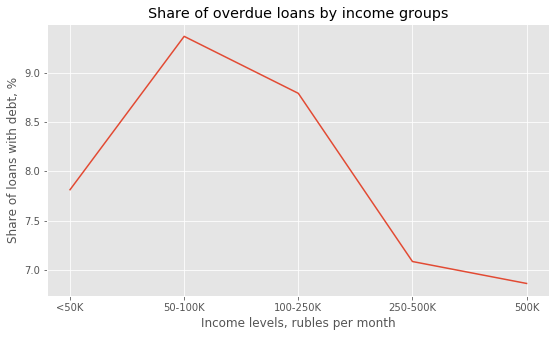

In [38]:
# summarizing the data on overdues by getting share of overdues by each income category
income_impact = df.groupby(["total_income_category"])["debt"].mean().reset_index()

# converting share to percentage
income_impact["debt"] = income_impact["debt"] * 100

# styling the graph
plt.style.use('ggplot')
plt.figure(figsize=(9, 5))
plt.plot(list(income_impact["total_income_category"]), list(income_impact["debt"]))
plt.title("Share of overdue loans by income groups")
plt.xlabel("Income levels, rubles per month")
plt.ylabel("Share of loans with debt, %");

-----------
Income level and Overdue loans are inter-connected not linearly to each other. The largest share of overdue loans is among people with a monthly income of 50-100K. The share of overdue loans rises both with an increase and a decrease in income from this level. These stylyzed fact might be explained as following:

- Clients with lower income are likely to be more disciplined in planning their expenses.
- Clients with income above 100K have more resources to repay the loan (even if they get additional non-anticipated expenses).

------------

#### 3.4. How do different purposes of a loan affect its repayment on time? <a name="purposes"></a>

Let's calculate the share of overdue loans among all issued loans by purpose category

In [39]:
purpose_impact = df.groupby("purpose_id")[["purpose_id","debt"]].mean().round(3).reset_index(drop=True)
purpose_impact = purpose_impact.merge(purpose_dict[["purpose_standard", "purpose_id"]], on = "purpose_id", how="left")
purpose_impact["purpose_id"] = purpose_impact["purpose_id"].astype("int")
purpose_impact[["purpose_standard", "debt"]].sort_values("debt", ascending=False).style.format({'debt': '{:.2%}'})

,purpose_standard,debt
3,education,9.80%
0,buy a car,9.50%
5,"business (purchase of commercial real estate, deal finance)",9.20%
4,wedding,8.30%
1,buy/build property,7.80%
2,repair property,6.00%


------------
**Interim Summary**

- *The largest share* of overdue loans were taken for the purpose of obtaining education. This is probably due to the fact that such loans are most often taken by people without a stable source of income, e.i. students.

- *The smallest share* is among those who take out a loan for property renovation/repair. Apparently, these are not the largest loan amounts, and also, probably, such borrowers have a stable income (since it would be difficult to assume that people who are not confident in the future would like to improve their living conditions at the expense of borrowed funds).

---------------

### 4. Final Summary <a name="final_summary"></a>

**Data Preprocessing**

1. The missing values (about a quarter of the rows of the entire dataset had such) were replaced with the corresponding median values grouped around variables without missing values.
2. The purposes of obtaining a loan were standardized using lemmatization.
3. The duplicates have been removed.
4. The following categorizations were added:
    - age groups;
    - income levels;
    - the purpose of obtaining a loan.

**Preliminary analysis of the relationship of creditworthiness with various parameters**

There is evidence from preliminary analysis that:
1. For loans taken by people who are/were married, the share of overdues is lower than that of loans taken by unmarried borrowers
2. For loans taken for various purposes, there is evidence of correspondingly varying levels of debt. Highest level of debt is asscoiated with loans issued for education.
3. Presence of children is also associated with a slightly higher share of overdued loans.

-------------------

### Backup <a name="backup"></a>

#### Backup 1. Verifying distribution similarity for variables within the dataset with and without missing values <a name="backupmissing"></a>

Approach:
1. Calculate share of overdue loans by each value of each variable in the overall dataset - `share_full`
2. Calculate share of overdue loans by each value of each variable in the dataset with missing values - `share_missing`
3. Calculate (absolute) difference between those shares - `abs_difference`

In [40]:
columns = ['children', 'dob_years', 'education_id', 'family_status_id','gender','income_type','debt']
for col in columns:
    col_count_missing = pd.DataFrame(df_missing[col].value_counts().sort_values())
    col_count_missing["share_missing"] = col_count_missing[col] / df_missing[col].value_counts().sum()

    col_count_full = pd.DataFrame(df[col].value_counts().sort_values())
    col_count_full["share_full"] = col_count_full[col] / df[col].value_counts().sum()
    
    merged = col_count_full.merge(col_count_missing, left_index=True, 
                                       right_index=True, how="outer").round(3)[["share_full", "share_missing"]]
    merged["abs_difference"] = abs(merged["share_full"] - merged["share_missing"])
    
    print(col)
    print(merged)
    print()

children
     share_full  share_missing  abs_difference
-1          NaN          0.001             NaN
 0        0.604          0.662           0.058
 1        0.259          0.218           0.041
 2        0.116          0.094           0.022
 3        0.018          0.017           0.001
 4        0.002          0.003           0.001
 5        0.001          0.000           0.001
 20         NaN          0.004             NaN

dob_years
    share_full  share_missing  abs_difference
0          NaN          0.005             NaN
19       0.001          0.000           0.001
20       0.003          0.002           0.001
21       0.006          0.008           0.002
22       0.010          0.008           0.002
23       0.014          0.017           0.003
24       0.015          0.010           0.005
25       0.020          0.011           0.009
26       0.023          0.016           0.007
27       0.028          0.017           0.011
28       0.029          0.026           0.003
29   

#### Backup 2. Analyzing data on days of employent  <a name="backupvisual"></a> 

In [41]:
# converting days into years
df_look = pd.read_csv("data.csv")
df_look["years_employed"] = df_look["days_employed"] / 365.25

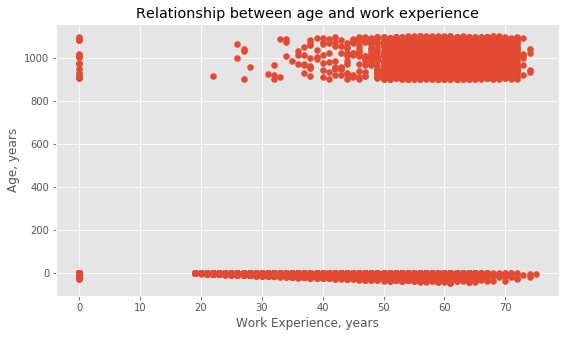

In [42]:
# graph age vs. work experience возраст vs. стаж
plt.figure(figsize=(9, 5))
plt.scatter(df_look["dob_years"], df_look["years_employed"])
plt.title("Relationship between age and work experience")
plt.xlabel("Work Experience, years")
plt.ylabel("Age, years");

Let's look into the lower cloud

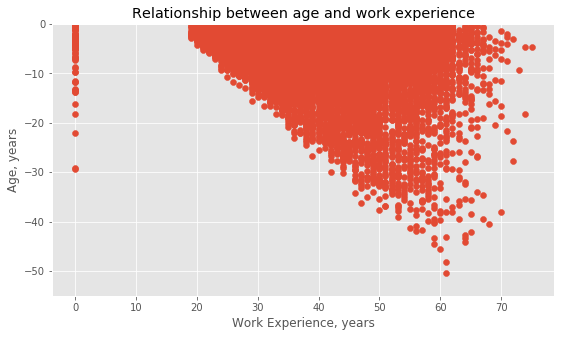

In [43]:
plt.figure(figsize=(9, 5))
plt.scatter(df_look["dob_years"], df_look["years_employed"])
plt.ylim(-55, 0)
plt.title("Relationship between age and work experience")
plt.xlabel("Work Experience, years")
plt.ylabel("Age, years");

<div class="alert alert-block alert-info">
    
We can observe a trend demonstrating that with increasing age the work experience grows (in negative values).
If you change the sign before the `work experience` to positive, the picture looks plausible.

Let's look into the upper cloud

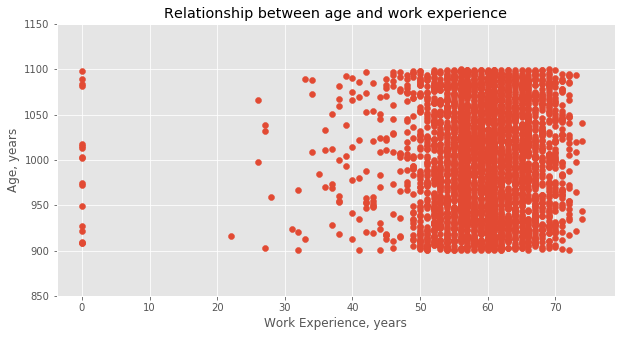

In [44]:
plt.figure(figsize=(10, 5))
plt.scatter(df_look["dob_years"], df_look["years_employed"])
plt.ylim(850, 1150)
plt.title("Relationship between age and work experience")
plt.xlabel("Work Experience, years")
plt.ylabel("Age, years");

<div class="alert alert-block alert-info">
    
The picture looks like some kind of noise.
Moreover, over 900 years of work experience doesn't seem like a plausible number.

End of the notebook